In [56]:
import torch
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import math
import time
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 300
from torch import distributions as dist

In [11]:
class perturbations():

    def __init__(self,func,num_samples,sigma,noise,batched):
        self.func = func
        self.num_samples = num_samples
        self.sigma = sigma
        self.noise = noise
        self.batched = batched
        
    def sample_noise_with_gradients(noise,shape):
        _GUMBEL = 'gumbel'
        _NORMAL = 'normal'
        SUPPORTED_NOISES = (_GUMBEL, _NORMAL)
        if noise not in SUPPORTED_NOISES:
            raise ValueError('{} noise is not supported. Use one of [{}]'.format(
            noise, SUPPORTED_NOISES))
        if noise == _GUMBEL:
            sampler = dist.gumbel.Gumbel(0.0, 1.0)
            samples = sampler.sample(shape)
            gradients = 1 - torch.exp(-samples)
        elif noise == _NORMAL:
            sampler = dist.normal.Normal(0.0, 1.0)
            samples = sampler.sample(shape)
            gradients = samples
        return samples, gradients

    def forward(self,input_tensor):
        original_input_shape = input_tensor.size()
        if self.batched:
            if original_input_shape[0] < 2:
                raise ValueError('Batched inputs must have at least rank two')
        else:  # Adds dummy batch dimension internally.
            input_tensor = torch.unsqueeze(input_tensor,0)
        input_shape = torch.tensor(input_tensor.size(),dtype=torch.int)  # [B, D1, ... Dk], k >= 1, Dimension of the tensor, in a sigle number.
        #input_shape = input_tensor.size()
        perturbed_input_shape = torch.cat((torch.tensor([self.num_samples]), input_shape)) #The storage space size for all perturbed sequence.

        noises = perturbations.sample_noise_with_gradients(self.noise, perturbed_input_shape) #Create noises
        additive_noise, noise_gradient = tuple([noise for noise in noises]) #Cast the noise to make the noise and input tensor operable
        perturbed_input = torch.unsqueeze(input_tensor, 0) + self.sigma * additive_noise #Add noises to the input tensor, if the expansion in dimension necessary tho?

        # [N, B, D1, ..., Dk] -> [NB, D1, ..., Dk].
        flat_batch_dim_shape = torch.cat((torch.tensor([-1]), input_shape[1:]))
        perturbed_input = torch.reshape(perturbed_input, tuple(flat_batch_dim_shape))
        # Calls user-defined function in a perturbation agnostic manner.
        perturbed_output = self.func(perturbed_input)
        # [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk].
        perturbed_input = torch.reshape(perturbed_input, tuple(perturbed_input_shape))
        # Either
        #   (Default case): [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk]
        # or
        #   (Full-reduce case) [NB] -> [N, B]
        perturbed_output_shape = torch.cat(
        (torch.tensor([self.num_samples]), torch.tensor([-1]), torch.tensor(perturbed_output.size()[1:])))
        perturbed_output = torch.reshape(perturbed_output, tuple(perturbed_output_shape))
        forward_output = torch.mean(perturbed_output,0)

        if not self.batched:
            forward_output = forward_output[0]
        self.original_input_shape = original_input_shape
        self.perturbed_input = perturbed_input
        self.noise_gradient = noise_gradient
        self.perturbed_output = perturbed_output
        return forward_output

    def backward(self,grad_output):
        if len(self.perturbed_input.size()) > len(self.perturbed_output.size()):
            self.grad_output = torch.unsqueeze(self.grad_output,-1)
            self.perturbed_output = torch.unsqueeze(self.perturbed_output,-1)
        if not self.batched:
            grad_output = torch.unsqueeze(grad_output,0)
        flatten = lambda t: torch.reshape(t, (t.size()[0], t.size()[1], -1))
        grad_output = torch.reshape(grad_output,(grad_output.size()[0],-1))
        self.perturbed_output = flatten(self.perturbed_output)
        noise_grad = flatten(self.noise_gradient)
        g = torch.einsum('nbd,nb->bd', self.noise_gradient,
                      torch.einsum('nbd,bd->nb', self.perturbed_output, grad_output))
        g = torch.mean(g,0)
        g /= self.sigma
        return g

In [27]:
def Sample_LinProg1(x):
#     x = x.clone().detach().numpy()
    solution = torch.zeros_like(x)
    for i in range(x.shape[0]):
        u = cp.Variable(2)
        coe = x[i].clone().detach().numpy()
        objec = lambda coe,u: cp.Minimize(coe@u)
        constraints = [u[0] >= 1,u[0]+u[1] <= 30, u>=0]
        prob = cp.Problem(objec(coe,u),constraints)
        prob.solve()
        solution[i] = torch.tensor(u.value)
    return solution

perturbed_Sample_Linprog1 = perturbations(Sample_LinProg1,200,1,'gumbel',False)

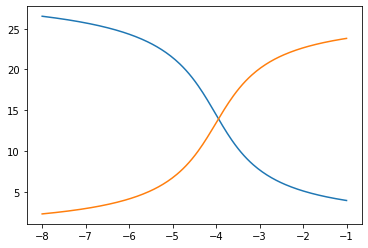

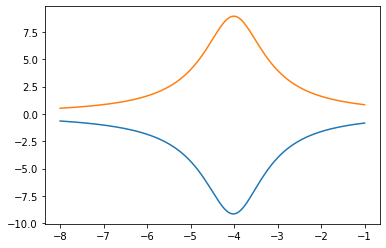

In [20]:
c = np.array([-1.,-4.])
n = len(c)
t = 0.1

def BF_gradient(t,u):
    dyy = np.ones((n,n))*(30-np.sum(u))**(-2) + np.diag((u+ np.array([-1,0]))**(-2))
    dxy = np.eye(n)*t
    return -np.linalg.inv(dyy)@dxy

def loss_grad(x_bar,x=np.array([1.,29.])):
    return 2*(x_bar - x)


x_value = np.linspace(-8,-1,200)
solution = np.zeros((len(x_value),n))
gradient = np.zeros((len(x_value),n))
for i in range(len(x_value)):
    c[0] = x_value[i]
    u = cp.Variable(n)
    objec = cp.Minimize(t*c@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
    prob = cp.Problem(objec)
    prob.solve()
    solution[i] = u.value
    gradient[i] = [BF_gradient(t,u.value)[0,0],BF_gradient(t,u.value)[0,1]]
plt.figure(1)
plt.plot(x_value,solution[:,0])
plt.plot(x_value,solution[:,1])
plt.figure(2)
plt.plot(x_value,gradient[:,0])
plt.plot(x_value,gradient[:,1])

Aiming for c = [-2, -4],
loss function $||c-\hat{c}||_2^2$

[26.5313077   2.27703505]
[ 1.7455594  27.50899953]


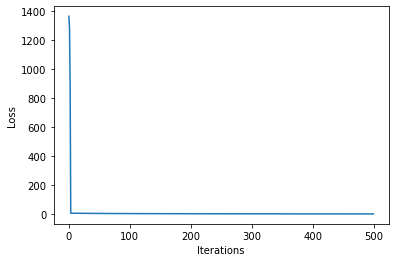

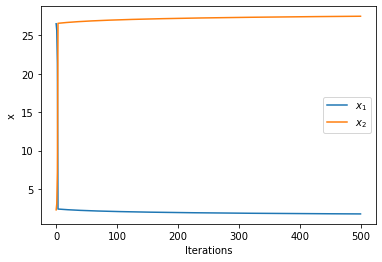

In [47]:
x = np.array([1.,29.])
# c = np.random.rand(2)
c = np.array([-8.,-4.])
u = cp.Variable(n)
t = 0.1
objec = cp.Minimize(t*c@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
prob = cp.Problem(objec)
prob.solve()
print(u.value)
max_iter = 500
loss_trac = []
solution_trac = np.zeros((max_iter,2))
for i in range(max_iter):
    u = cp.Variable(n)
    objec = cp.Minimize(t*c@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
    prob = cp.Problem(objec)
    prob.solve()
    loss = np.linalg.norm(u.value-x,2)**2
    loss_trac.append(loss)
    solution_trac[i] = u.value
    loss_gradient = loss_grad(u.value,x)
    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c - 0.01*loss_gradient @ BF_gradient(t,u.value)
print(u.value)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.legend()

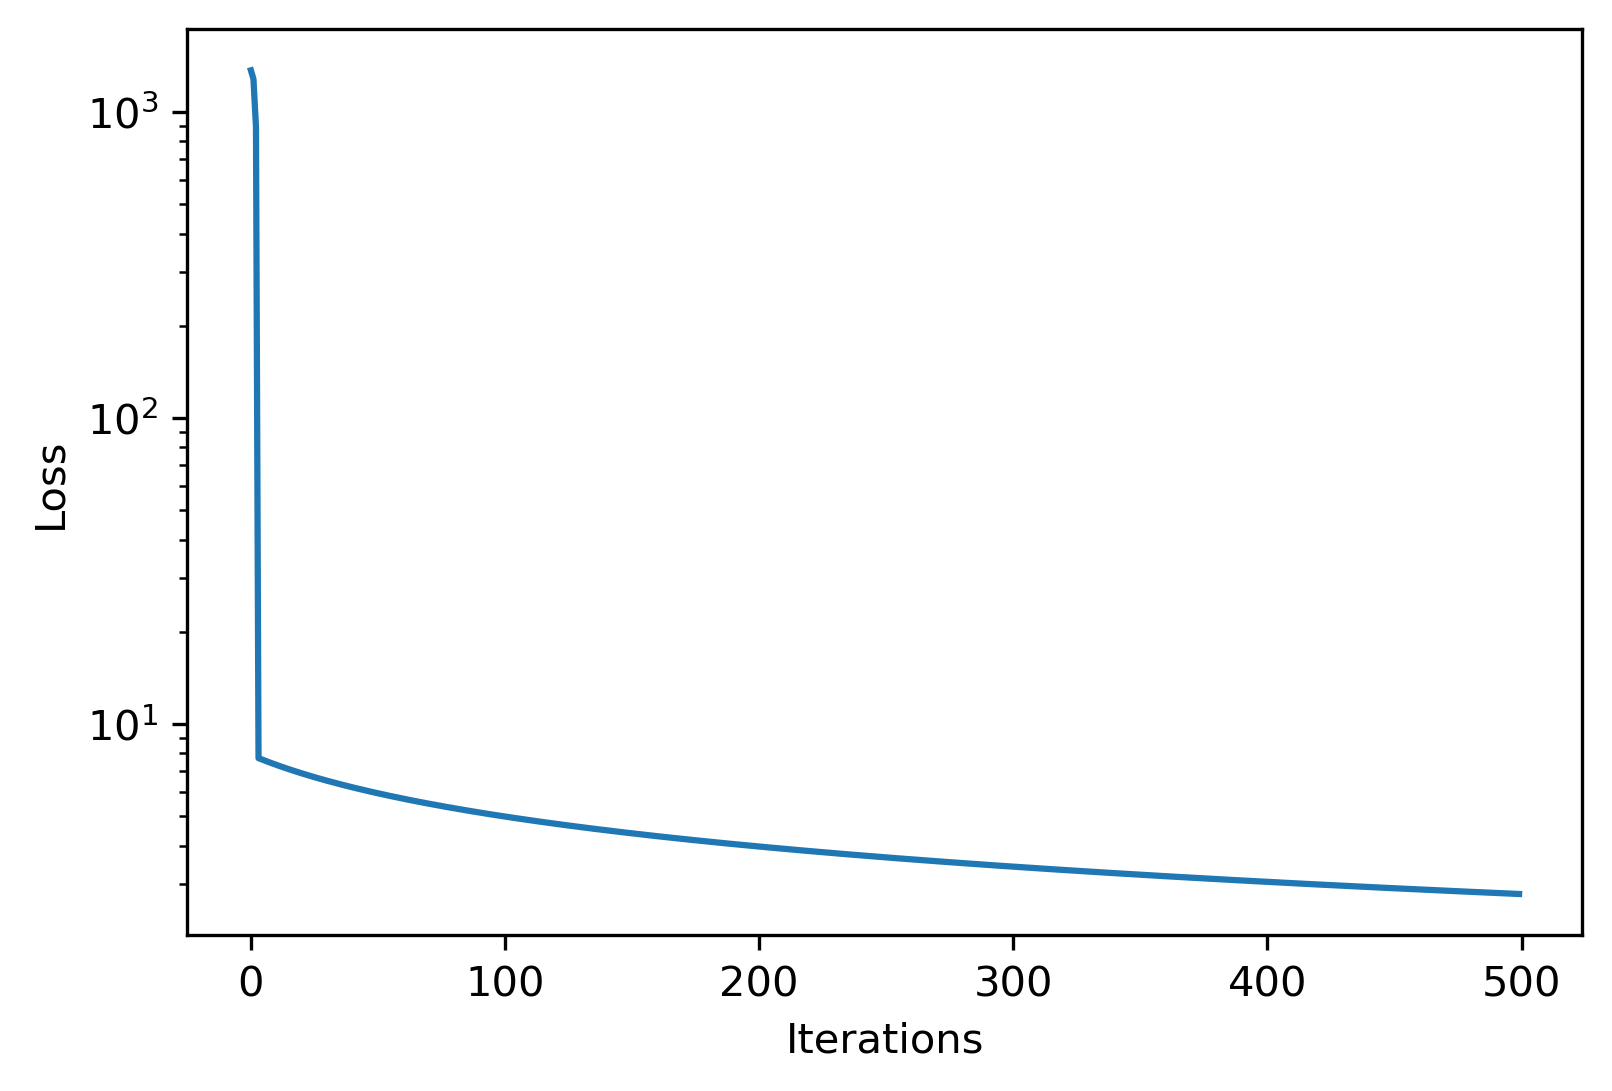

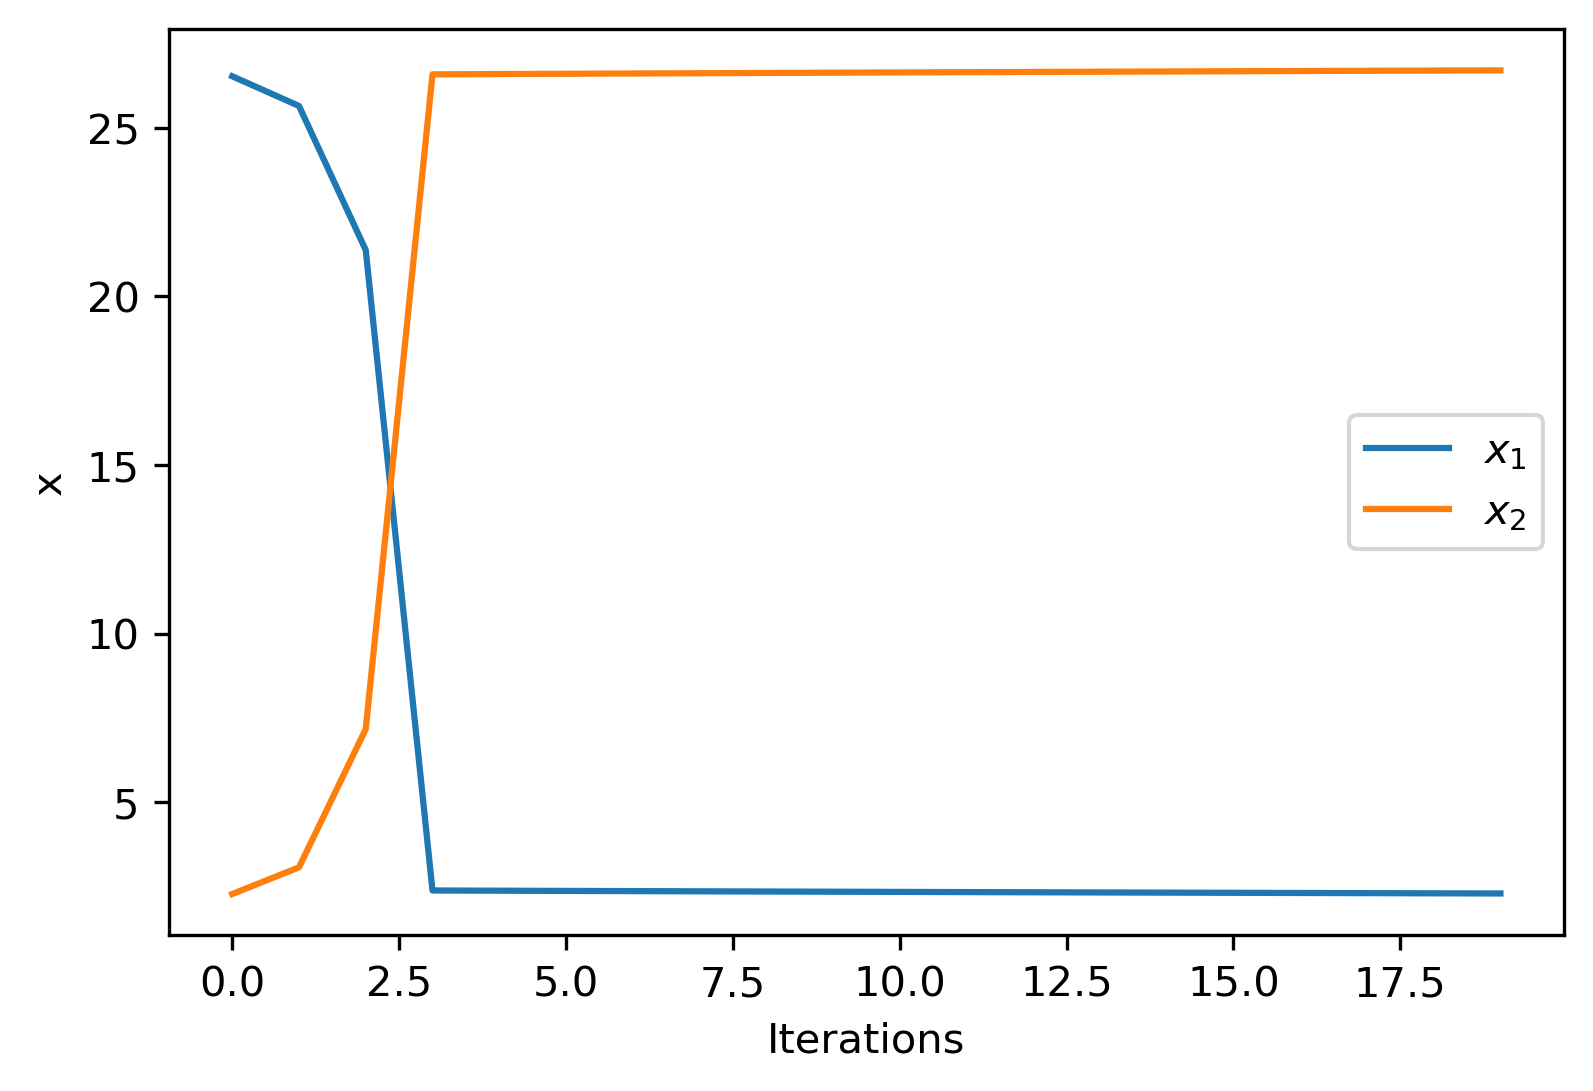

In [57]:
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.figure(2)
plt.plot(solution_trac[:20,0],label = '$x_1$')
plt.plot(solution_trac[:20,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.legend()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

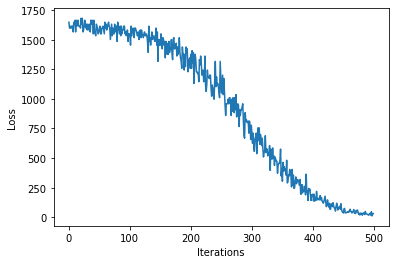

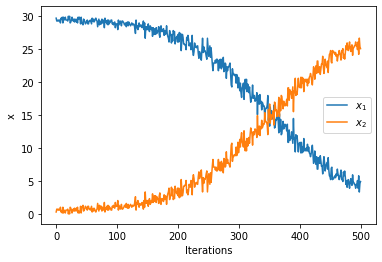

In [30]:
def loss_grad(x_bar,x=torch.tensor([1.,29.])):
    return 2*(x_bar - x)

x = torch.tensor([1.,29.])
# c = np.random.rand(2)
c = torch.tensor([-8.,-4.])
# u = cp.Variable(n)
# t = 0.1
# objec = cp.Minimize(t*c@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
# prob = cp.Problem(objec)
# prob.solve()
# print(u.value)
max_iter = 500
loss_trac = []
solution_trac = []
for i in range(max_iter):
    print(i)
    solution = perturbed_Sample_Linprog1.forward(c)
    loss = torch.linalg.norm(solution-x,2)**2
    loss_gradient = loss_grad(solution)
    solution_grad = perturbed_Sample_Linprog1.backward(loss_gradient)
    loss_trac.append(loss)
    solution_trac.append(solution)

    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c - 0.01*(solution_grad/torch.linalg.norm(solution_grad,2))
#     print(solution_grad)
#     print(c)
solution_trac = torch.stack(solution_trac,dim=0)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.legend()

In [32]:
solution

tensor([ 4.9150, 25.0850])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


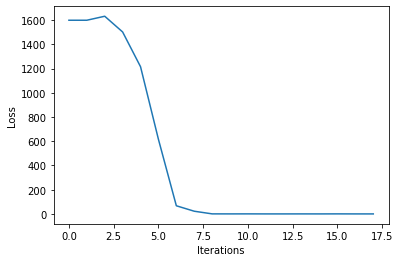

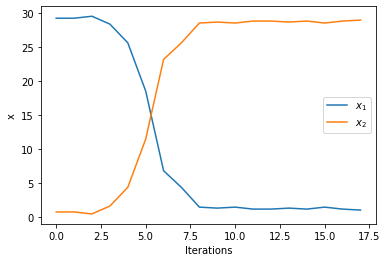

In [33]:
def loss_grad(x_bar,x=torch.tensor([1.,29.])):
    return 2*(x_bar - x)

x = torch.tensor([1.,29.])
# c = np.random.rand(2)
c = torch.tensor([-8.,-4.])
# u = cp.Variable(n)
# t = 0.1
# objec = cp.Minimize(t*c@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
# prob = cp.Problem(objec)
# prob.solve()
# print(u.value)
max_iter = 500
loss_trac = []
solution_trac = []
for i in range(max_iter):
    print(i)
    solution = perturbed_Sample_Linprog1.forward(c)
    loss = torch.linalg.norm(solution-x,2)**2
    loss_gradient = loss_grad(solution)
    solution_grad = perturbed_Sample_Linprog1.backward(loss_gradient)
    loss_trac.append(loss)
    solution_trac.append(solution)

    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c -  (solution_grad/torch.linalg.norm(solution_grad,2))
#     print(solution_grad)
#     print(c)
solution_trac = torch.stack(solution_trac,dim=0)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.legend()

In [34]:
print(loss_trac[-1])
print(solution)

tensor(0.)
tensor([ 1., 29.])


In [36]:
#Objective function and its partial derivatives
def objective(t,x,u):
    return t*x@u-np.log(u[1]-1)-np.log(4-u[1])-np.log(8-u[1]+u[0])-np.log(u[1]-4-u[0])-np.log(u[0]+u[1]+3) -np.log(1-u[0]-u[1])
def objective_dy(t,x,u):
    return np.array([t*x[0]-np.power(8-u[1]+u[0],-1)+np.power(u[1]-4-u[0],-1)-np.power(u[0]+u[1]+3,-1)+np.power(1-u[0]-u[1],-1), \
    t*x[1]-np.power(u[1]-1,-1)+np.power(4-u[1],-1)+np.power(8-u[1]+u[0],-1)-np.power(u[1]-4-u[0],-1)-np.power(u[0]+u[1]+3,-1)+np.power(1-u[0]-u[1],-1)])
def objective_dxy(t):
     return np.matrix([[t,0],\
                      [0,t]])
def objective_dyy(u):
    return np.matrix([[np.power(8-u[1]+u[0],-2)+np.power(u[1]-4-u[0],-2)+np.power(1-u[0]-u[1],-2)+np.power(u[0]+u[1]+3,-2),-np.power(8-u[1]+u[0],-2)-np.power(u[1]-4-u[0],-2)+np.power(u[0]+u[1]+3,-2)+np.power(1-u[0]-u[1],-2)],[-np.power(8-u[1]+u[0],-2)-np.power(u[1]-4-u[0],-2)+np.power(u[0]+u[1]+3,-2)+np.power(1-u[0]-u[1],-2),np.power(u[1]-1,-2)+np.power(4-u[1],-2)+np.power(8-u[1]+u[0],-2)+np.power(u[1]-u[0]-4,-2)+np.power(u[0]+u[1]+3,-2)+np.power(1-u[0]-u[1],-2)]])
def objective_gradient(t,u):
    return -np.linalg.inv(objective_dyy(u))@objective_dxy(t)

def loss_grad(x_bar,x=np.array([-4.,4.])):
    return 2*(x_bar - x)


In [ ]:
rads = np.linspace(0,2*math.pi,200)
u_data0 = []
u_data1 = []
gradient00 = []
gradient01 = []
gradient10 = []
gradient11 = []
time_cost = []
for val in rads:
    x = np.array([math.cos(val),math.sin(val)])
    u = cp.Variable(2)
    #Initialise barrier coefficient t
    t = 0.5
    start = time.time()
    objec = lambda u: cp.Minimize(t*x@u-cp.log(u[1]-10)-cp.log(40-u[1])-cp.log(80-u[1]+u[0])-cp.log(u[1]-40-u[0])-cp.log(u[0]+u[1]+30)-cp.log(10-u[0]-u[1]))
    #Solving the problem with CVXPY
    prob = cp.Problem(objec(u))
    prob.solve()
    end = time.time()
    time_cost.append(end-start)
    u_data0.append(u.value[0])
    u_data1.append(u.value[1])
    #Determine the gradient of the solution with the derived equation
    gradient = objective_gradient(t,u.value)
    gradient00.append(gradient[0,0])
    gradient01.append(gradient[1,0])
    gradient10.append(gradient[0,1])
    gradient11.append(gradient[1,1])

print("The average time cost to determine a barriered output is %f" %np.mean(time_cost))
fig, axs = plt.subplots(3)
ttl = fig.suptitle('Solving by BF')
ttl.set_position([.5, 1.05])
axs[0].plot(rads,u_data0,label = 'u1')
axs[0].plot(rads,u_data1,label = 'u2')
axs[1].plot(rads,gradient00)
axs[1].plot(rads,gradient01)
axs[2].plot(rads,gradient10)
axs[2].plot(rads,gradient11)
axs[0].set_title('u against radius change in x')
axs[1].set_title('gradient of u against x[0]')
axs[2].set_title('gradient of u against x[1]')
fig.tight_layout()
fig.legend()

[-2.34182423  1.91087508]
[[-0.55213242  0.24023001]]
[[-0.55426484  0.23046001]]
[[-0.55639725  0.22069002]]
[[-0.55852967  0.21092002]]
[[-0.56066209  0.20115003]]
[[-0.56279451  0.19138003]]
[[-0.56492693  0.18161004]]
[[-0.56705934  0.17184004]]
[[-0.56919176  0.16207005]]
[[-0.57132418  0.15230005]]
[[-0.5734566   0.14253006]]
[[-0.57558902  0.13276007]]
[[-0.57772144  0.12299007]]
[[-0.57985385  0.11322008]]
[[-0.58198627  0.10345008]]
[[-0.58411869  0.09368009]]
[[-0.58625111  0.08391009]]
[[-0.58838353  0.0741401 ]]
[[-0.59051594  0.0643701 ]]
[[-0.59264836  0.05460011]]
[[-0.59478078  0.04483011]]
[[-0.5969132   0.03506012]]
[[-0.59904562  0.02529013]]
[[-0.60117803  0.01552013]]
[[-0.60331045  0.00575014]]
[[-0.60544287 -0.00401986]]
[[-0.60757529 -0.01378985]]
[[-0.60970771 -0.02355985]]
[[-0.61184013 -0.03332984]]
[[-0.61397254 -0.04309984]]
[[-0.61610496 -0.05286983]]
[[-0.61823738 -0.06263982]]
[[-0.6203698  -0.07240982]]
[[-0.62250222 -0.08217981]]
[[-0.62463463 -0.09194

[[-1.18119576 -2.64191838]]
[[-1.18332818 -2.65168837]]
[[-1.1854606  -2.66145837]]
[[-1.18759302 -2.67122836]]
[[-1.18972543 -2.68099836]]
[[-1.19185785 -2.69076835]]
[[-1.19399027 -2.70053835]]
[[-1.19612269 -2.71030834]]
[[-1.19825511 -2.72007834]]
[[-1.20038752 -2.72984833]]
[[-1.20251994 -2.73961832]]
[[-1.20465236 -2.74938832]]
[[-1.20678478 -2.75915831]]
[[-1.2089172  -2.76892831]]
[[-1.21104961 -2.7786983 ]]
[[-1.21318203 -2.7884683 ]]
[[-1.21531445 -2.79823829]]
[[-1.21744687 -2.80800829]]
[[-1.21957929 -2.81777828]]
[[-1.22171171 -2.82754828]]
[[-1.22384412 -2.83731827]]
[[-1.22597654 -2.84708826]]
[[-1.22810896 -2.85685826]]
[[-1.23024138 -2.86662825]]
[[-1.2323738  -2.87639825]]
[[-1.23450621 -2.88616824]]
[[-1.23663863 -2.89593824]]
[[-1.23877105 -2.90570823]]
[[-1.24090347 -2.91547823]]
[[-1.24303589 -2.92524822]]
[[-1.2451683  -2.93501821]]
[[-1.24730072 -2.94478821]]
[[-1.24943314 -2.9545582 ]]
[[-1.25156556 -2.9643282 ]]
[[-1.25369798 -2.97409819]]
[[-1.2558304  -2.983

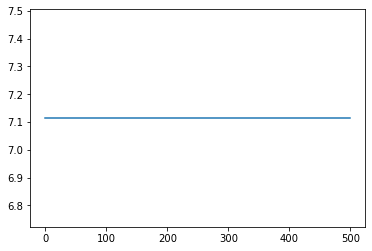

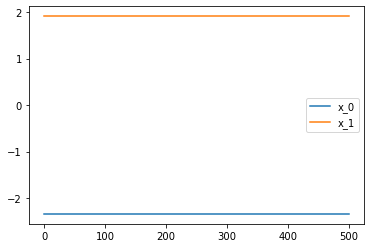

In [43]:
x = np.array([-4.,4.])
c = np.array([-0.55,0.25])
u = cp.Variable(2)
t = 1
objec = cp.Minimize(t*x@u-cp.log(u[1]-1)-cp.log(4-u[1])-cp.log(8-u[1]+u[0])-cp.log(u[1]-4-u[0])-cp.log(u[0]+u[1]+3)-cp.log(1-u[0]-u[1]))
prob = cp.Problem(objec)
prob.solve()
print(u.value)
max_iter = 500
loss_trac = []
solution_trac = np.zeros((max_iter,2))
for i in range(max_iter):
    u = cp.Variable(n)
    objec = cp.Minimize(t*x@u-cp.log(u[1]-1)-cp.log(4-u[1])-cp.log(8-u[1]+u[0])-cp.log(u[1]-4-u[0])-cp.log(u[0]+u[1]+3)-cp.log(1-u[0]-u[1]))
    prob = cp.Problem(objec)
    prob.solve()
    loss = np.linalg.norm(u.value-x,2)**2
    loss_trac.append(loss)
    solution_trac[i] = u.value
    loss_gradient = loss_grad(u.value,x)
    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    update_gradient = loss_gradient @ objective_gradient(t,u.value)
    c = c - 0.01*(update_gradient/np.linalg.norm(update_gradient,2))
    print(c)
print(u.value)
plt.figure(1)
plt.plot(loss_trac)
plt.figure(2)
plt.plot(solution_trac[:,0],label = 'x_0')
plt.plot(solution_trac[:,1],label = 'x_1')
plt.legend()

In [ ]:
def BF_gradient(t,u):
    dyy = np.ones((n,n))*(30-np.sum(u))**(-2) + np.diag((u+ np.array([-1,0]))**(-2))
    dxy = np.eye(n)*t
    return -np.linalg.inv(dyy)@dxy

def loss_grad(x_bar,x=np.array([1.,29.])):
    return 2*(x_bar - x)

In [45]:
def Sample_LinProg2(x):
    solution = torch.zeros_like(x)
    for i in range(x.shape[0]):
        u = cp.Variable(2)
        coe = x[i].clone().detach().numpy()
        objec = lambda coe,u: cp.Minimize(coe@u)
        constraints = [u[1]+u[0]<=1,u[0]+u[1] >= -3, u[1] - u[0] >=4 , u[1] - u[0] <= 8, u[1]<=4, u[1] >=1]
        prob = cp.Problem(objec(coe,u),constraints)
        prob.solve(warm_start=True)
        solution[i,:] = torch.tensor(u.value)
    return solution

perturbed_Sample_Linprog2 = perturbations(Sample_LinProg2,num_samples=200,
                                      sigma=0.5,
                                      noise='gumbel',
                                      batched=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

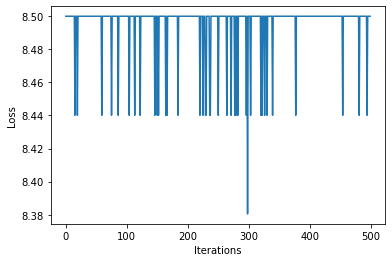

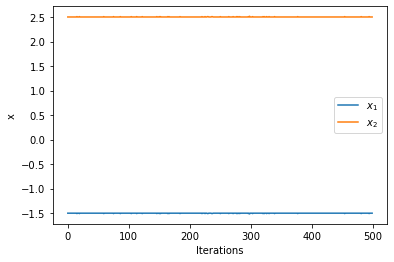

In [46]:
def loss_grad(x_bar,x=torch.tensor([1.,29.])):
    return 2*(x_bar - x)
x = torch.tensor([-4.,4.])
c = torch.tensor([-8.,-4.])
max_iter = 500
loss_trac = []
solution_trac = []
for i in range(max_iter):
    print(i)
    solution = perturbed_Sample_Linprog2.forward(c)
    loss = torch.linalg.norm(solution-x,2)**2
    loss_gradient = loss_grad(solution)
    solution_grad = perturbed_Sample_Linprog2.backward(loss_gradient)
    loss_trac.append(loss)
    solution_trac.append(solution)

    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c - 0.01*(solution_grad/torch.linalg.norm(solution_grad,2))
#     print(solution_grad)
#     print(c)
solution_trac = torch.stack(solution_trac,dim=0)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.legend()